In [3]:
import logging
logging.basicConfig(level=logging.DEBUG)
from getData import getData
from arabic_load import get_train_data, get_test_data
import numpy as np

# 1. Load data

In [2]:
X_train_bme, y_train_bme, X_test_bme, y_test_bme = getData('BME', '../data/UCR/raw_data/')
len(X_train_bme), len(X_test_bme)

(30, 150)

In [4]:
X_train_arabic, y_train_arabic = get_train_data()
X_test_arabic, y_test_arabic = get_test_data()
len(X_train_arabic), len(X_test_arabic)

(6600, 2200)

In [9]:
import matplotlib.pyplot as plt
def heat_map(M):
    plt.imshow(M, cmap='viridis')
    plt.colorbar()
    plt.show()

# 2. Optimal transport metric

## 2.1. OPW

In [11]:
import numpy as np
import math
from ot.bregman import sinkhorn, sinkhorn2
from ot.utils import list_to_array
import ot
import torch

In [6]:
def get_E_F(N, M):
    mid_para = np.sqrt((1/(N**2) + 1/(M**2)))

    a_n = np.arange(start=1, stop=N+1)
    b_m = np.arange(start=1, stop=M+1)
    row_col_matrix = np.meshgrid(a_n, b_m) 
    row = row_col_matrix[0].T / N 
    col = row_col_matrix[1].T / M 

    l = np.abs(row - col) / mid_para

    E =  1 / ((row - col) ** 2 + 1)
    F = l**2
    return E, F

In [7]:
def opw_sinkhorn(a, b, M,lambda1=50, lambda2=0.1, delta=1, method='sinkhorn', numItermax=1000, stopThr=1e-9, verbose=False, log=False, warn=True, **kwargs):
    r"""
    Solve the entropic regularization OPW and return the loss

    Args:
        X (ndarray): view1
        Y (ndarray): view2
        lambda1 (int, optional): weight of first term. Defaults to 50.
        lambda2 (float, optional): weight of second term. Defaults to 0.1.
        delta (int, optional): _description_. Defaults to 1.

    Returns:
        distance: distance is the distance between views
    """

    a, b, M = list_to_array(a, b, M)

    reg = lambda2

    E, F = get_E_F(a.shape[0], b.shape[0])
    M_hat = M - lambda1 * E + lambda2 * (F / (2 * delta ** 2) + np.log(delta * np.sqrt(2 * math.pi)))

    cost = sinkhorn2(a, b, M_hat, reg,method=method, numItermax=numItermax, stopThr=stopThr, verbose=verbose, log=log, warn=warn, **kwargs)
    transport_matrix = sinkhorn(a, b, M_hat, reg, method=method, numItermax=numItermax, stopThr=stopThr, verbose=verbose, log=log, warn=warn, **kwargs)
    return cost, transport_matrix

In [8]:
def opw_distance(M, lambd=1e-1, numItermax=100):
    rows, cols = M.shape
    a, b = np.ones((rows,)) / rows, np.ones((cols,)) / cols
    dist, matrix = opw_sinkhorn(a, b, M, lambd=lambd, numItermax=numItermax)
    return torch.tensor(dist), matrix

In [37]:
def test_OPW(xs, xt, numItermax=10000, data="arabic"):
    if data == "arabic":
        M = ot.dist(X_train_arabic[xs], X_test_arabic[xt], metric="euclidean")
        print(len(X_train_arabic[xs]), len(X_test_arabic[xt]))
    else:
        M = ot.dist(X_train_bme[xs], X_test_bme[xt], metric="euclidean")
        print(len(X_train_bme[xs]), len(X_test_bme[xt]))
    cost, matrix = opw_distance(M=M, numItermax=numItermax)
    print(cost)
    heat_map(matrix)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x00000192C44F6E10>


31 37
tensor(-46.2843, dtype=torch.float64)


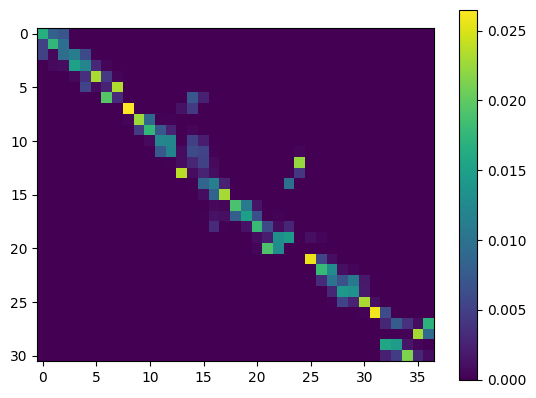

In [38]:
test_OPW(xs=13, xt=59)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x00000192C5809210>


31 37
tensor(-46.2935, dtype=torch.float64)


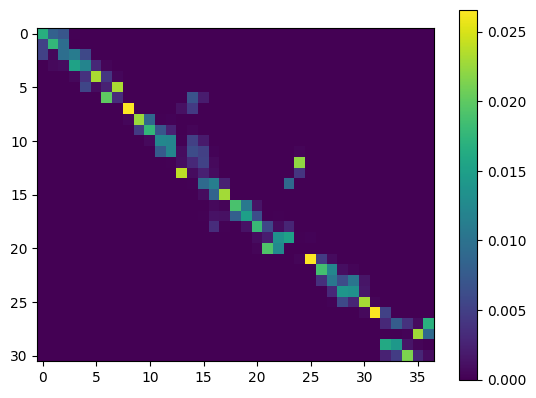

In [42]:
test_OPW(xs=13, xt=59, numItermax=1000)

## 2.2. New OT

In [16]:
def create_I(n, m):
    a_n = np.arange(start=1, stop=n+1)
    b_m = np.arange(start=1, stop=m+1)
    row_col_matrix = np.meshgrid(a_n, b_m)
    row = row_col_matrix[0].T / n
    col = row_col_matrix[1].T / m
    I = 1 / ((row - col)**2 + 1)
    return I

In [17]:
def create_neighbor_relationship(xs):
    xs = np.array(xs)
    if xs.ndim == 1:
        xt = np.insert(xs, 0, np.zeros_like(xs[0]))[:-1]
        f = xs - xt
        f = f.reshape(-1, 1)
    else:
        xt = np.vstack((np.zeros_like(xs[0]),xs))[:-1]
        f = xs - xt
    d = np.linalg.norm(f, axis=1)
    f1 = np.cumsum(d)
    sum_dist = f1[len(f1)-1]
    return f1/sum_dist

In [18]:
def create_mask_KL(xs, xt, type=1):
    f1 = create_neighbor_relationship(xs)
    f2 = create_neighbor_relationship(xt)
    n = len(f1)
    m = len(f2)
    mid_para = np.sqrt((1/(n**2) + 1/(m**2)))
    M = np.zeros((n, m))
    for i in range(0, n):
        for j in range(0, m):
            if type == 1:
                if f1[i] == f2[j]:
                    M[i][j] = 1
                else: 
                    M[i][j] = max(f1[i], f2[j])/min(f1[i], f2[j])
            else:
                M[i][j] = np.abs(f1[i] - f2[j])/mid_para
    return M**2

In [19]:
def cost_matrix_2d(x, y):
    m = len(x)
    n = len(y)
    Cxy = np.zeros((m, n))
    for row in range(m):
        for col in range(n):
            Cxy[row, col] = np.linalg.norm(x[row] - y[col])
    return Cxy

In [23]:
I = create_I(len(X_train_arabic[13]), len(X_train_arabic[59]))
KL = create_mask_KL(X_train_arabic[13], X_train_arabic[59], type=2)
M = cost_matrix_2d(X_train_arabic[13], X_train_arabic[59])
I.shape, KL.shape, M.shape

((31, 43), (31, 43), (31, 43))

In [24]:
def opw_sinkhorn_new(a, b, M,KL, lambda1=50, lambda2=0.1, delta=1, method='sinkhorn', numItermax=1000, stopThr=1e-9, verbose=False, log=False, warn=True, **kwargs):
    r"""
    Solve the entropic regularization OPW and return the loss

    Args:
        X (ndarray): view1
        Y (ndarray): view2
        lambda1 (int, optional): weight of first term. Defaults to 50.
        lambda2 (float, optional): weight of second term. Defaults to 0.1.
        delta (int, optional): _description_. Defaults to 1.

    Returns:
        distance: distance is the distance between views
    """

    a, b, M, KL = list_to_array(a, b, M, KL)

    reg = lambda2

    I = create_I(a.shape[0], b.shape[0])
    M_hat = M - lambda1 * I + lambda2 * (KL / (2 * delta ** 2) + np.log(delta * np.sqrt(2 * math.pi)))

    cost = sinkhorn2(a, b, M_hat, reg,method=method, numItermax=numItermax, stopThr=stopThr, verbose=verbose, log=log, warn=warn, **kwargs)
    translation_matrix = sinkhorn(a, b, M_hat, reg, method=method, numItermax=numItermax, stopThr=stopThr, verbose=verbose, log=log, warn=warn, **kwargs)
    return cost, translation_matrix, M_hat

In [26]:
def new_distance(M, KL, lambd=1e-1, numItermax=100):
    rows, cols = M.shape
    a, b = np.ones((rows,)) / rows, np.ones((cols,)) / cols
    dist, matrix, M_hat = opw_sinkhorn_new(a, b, M, KL, lambd, numItermax=numItermax)
    return torch.tensor(dist), matrix, M_hat

In [55]:
def test_new_OT(xs, xt, numItermax=1000, data="arabic", type=2):
    if data == "arabic":
        M = cost_matrix_2d(X_train_arabic[xs], X_test_arabic[xt])
        KL = create_mask_KL(X_train_arabic[xs], X_test_arabic[xt], type=type)
        print(len(X_train_arabic[xs]), len(X_test_arabic[xt]))
    else:
        M = cost_matrix_2d(X_train_bme[xs], X_test_bme[xt])
        KL = create_mask_KL(X_train_bme[xs], X_test_bme[xt], type=type)
        print(len(X_train_bme[xs]), len(X_test_bme[xt]))
    cost, matrix, M_hat = new_distance(M=M, KL=KL, numItermax=numItermax)
    print(cost)
    heat_map(matrix)
    return M_hat

128 128


c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\ot\bregman.py:536: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x00000192D71D6410>


tensor(1.0070, dtype=torch.float64)


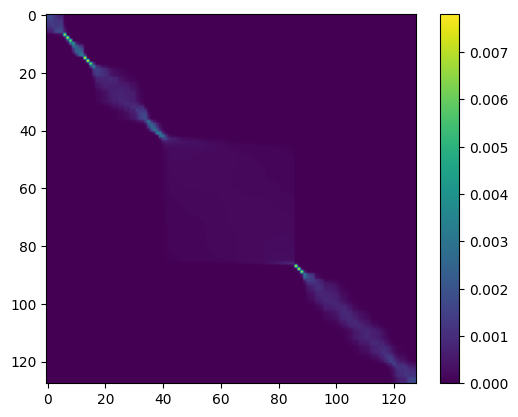

In [103]:
M_hat = test_new_OT(3, 37, data="bme", type=2)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x00000192C3E62D50>


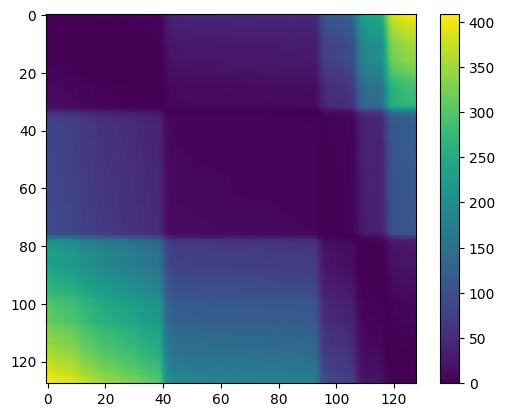

In [57]:
heat_map(M_hat)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x00000192C57A86D0>


31 37
tensor(3.3678, dtype=torch.float64)


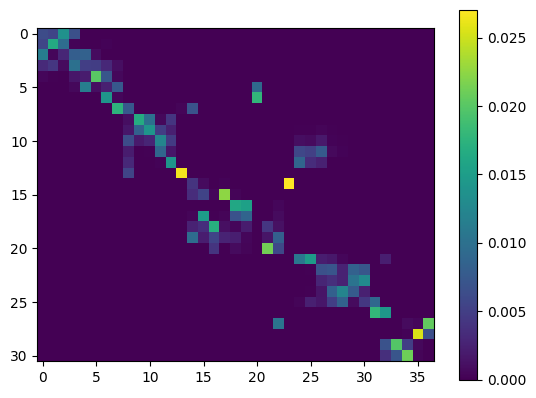

In [49]:
test_new_OT(13, 59)

## 2.3. Other metric

In [100]:
import numpy as np
from scipy.spatial.distance import cdist

def cost_matrix_1d(x, y):
    x = np.array(x).reshape(-1, 1)
    y = np.array(y).reshape(1, -1)
    Cxy = (x - y) ** 2
    return Cxy

def opw(x, y, a=None, b=None, lambda1=50, lambda2=12.1, sigma=1, VERBOSE=1, type=1):
    """
    Order-preserving Wasserstein Distance (OPW) aligning
    :param x: first sequence to align. shape=(N1,d) d > 2
    :param y: second sequence to align. shape=(N2,d) d > 2
    :param a: weights of the first points sequence. If none uniform weights are used
    :param b: weights of the second points sequence. If none uniform weights are used
    :param lambda1: regularization term for the inverse difference moment (to be tuned)
    :param lambda2: regularization term for Kullback-Leibler (KL) (to be tuned)
    :param sigma: variance of the gaussian distribution
    :param VERBOSE: whether display the iteration status
    :return: distance (float value), transport matrix T, shape=(N1,N2)
    """
    tol = 0.005
    max_iter = 20  # higher means more accurate transport vector
    N, M = x.shape[0], y.shape[0]
    if (x.size / x.shape[0]) != (y.size / y.shape[0]):
        raise Exception(f'The dimension of the sequence must be the same, x: {x.shape} y: {y.shape}')

    p = np.zeros((N, M))
    s = np.zeros((N, M))
    F = create_mask_KL(x, y, type=type)


    # param in the middle on which center the gaussian (see later)
    mid_para = np.sqrt(1 / np.power(N, 2) + 1 / np.power(M, 2))
    for i in range(N):
        for j in range(M):
            # indexing starts from 0, but we are considering the first position
            diag = np.abs((i + 1) / N - (j + 1) / M) / mid_para

            # Gaussian distribution centered at the intersection on the diagonal
            # (prior distribution of the transport matrix)
            p[i, j] = np.exp(-np.power(F[i][j], 2) / 2 * np.power(sigma, 2)) / (sigma * np.sqrt(2 * np.pi))

            # constant defined at page 6 of the OPW paper
            s[i, j] = lambda1 / (np.power(((i + 1) / N - (j + 1) / M), 2) + 1)

    # pairwise distance between x and y
    if x.ndim == 2:
        d = cdist(x, y, 'sqeuclidean')
    else:
        d = cost_matrix_1d(x, y)
    ''' 
    In cases the instances in sequences are not normalized and/or are very high-dimensional, the matrix D can be
    normalized or scaled as follows: D = D/max(max(D));  D = D/(10^2)
    '''

    k = p * np.exp((s - d) / lambda2)  # every operator "*", "/" means element wise
    '''
    With some parameters, some entries of K may exceed the matching-precision limit; in such cases, you may need
    to adjust the parameters, and/or normalize the input features in sequences or the matrix D; Please see the paper for
    details. In practical situations it might be a good idea to do the following: K(K<1e-100)=1e-100;
    '''

    if a is None: a = np.ones((N, 1)) / N
    if b is None: b = np.ones((M, 1)) / M

    ainvK = k / a
    compt = 0

    '''
    Dual-Sinkhorn divergence is the dual problem of the Sinkhorn Distance; this is cheaper to compute. In the new defined 
    problem (see page 4 of https://papers.nips.cc/paper/4927-sinkhorn-distances-lightspeed-computation-of-optimal-transport.pdf)
    the value of P^lambda (the solution), thanks to the entropy regularization, can be computed as diag(u)*K*diag(v), 
    where u and v are two non-negative vectors of R^d uniquely defined up to a multiplicative factor.
    '''
    u = np.ones((N, 1)) / N  # initialization of left scaling factors
    v = None

    # Sinkhorn Distances
    while compt < max_iter:
        # for real value there aren't differences in the transpose operation ( a' vs a.' in Matlab)
        u = 1 / (np.dot(ainvK, (b / (np.dot(np.transpose(k), u)))))
        compt += 1

        # check the stopping criterion every 20 fixed point iterations
        if (compt % 20) == 1 or compt == max_iter:
            # split computations to recover right and left scalings.
            v = b / np.dot(np.transpose(k), u)  # main iteration of Sinkhorn's algorithm
            u = 1 / np.dot(ainvK, v)

            # check if the value of diag(u) * K *diag(v) is smaller than the tolerance value. Remember that this is the
            # solution of the Dual-Sinkhorn divergence problem
            criterion = np.linalg.norm(np.sum(np.abs(v * (np.dot(np.transpose(k), u)) - b), axis=0), np.inf)
            if criterion < tol:
                print(f'Convergence reached, criterion: {criterion} tol: {tol}')
                break
            if np.isnan(criterion):
                raise Exception('NaN values have appeared during the fixed point iteration. This problem appears '
                                'because of insufficient machine precision when processing computations with a '
                                'regularization value of lambda2 that is too high. '
                                'Try again with a reduced regularization parameter lambda (1 or 2) or with a '
                                'thresholded metric matrix d.')

            compt += 1
            if VERBOSE > 0:
                print(f'Iteration: {compt}, Criterion: {criterion}')

    U = k * d
    dist = np.sum(u * np.dot(U, v), axis=0)
    T = np.transpose(v) * (u * k)

    return dist, T


def transport_vector_to_path(T):
    """
    Given a transport vector T generated aligning two sequences of dimension (N1,d), (N2,d), extract the sequences
    aligning path
    :param T: vector, shape=(N1,N2)
    :return: path, shape=(max(N1,N2),)
    """
    path = []
    if T.shape[0] > T.shape[1]:
        for s1 in range(T.shape[0]):
            path.append((s1, np.argmax(T[s1])))
    else:
        T = np.transpose(T)
        for s1 in range(T.shape[0]):
            path.append((np.argmax(T[s1]), s1))
    return path

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x00000192C58A2F90>


Iteration: 2, Criterion: 0.31919940154300036
Iteration: 21, Criterion: 0.14303004929703506
[45.92664429]


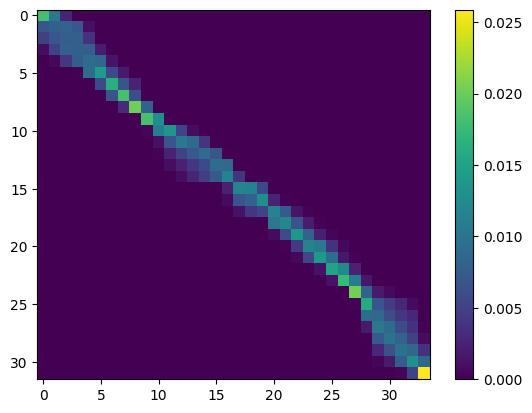

In [101]:
a,b = opw(X_train_arabic[553], X_train_arabic[37], type=2)
print(a)
heat_map(b)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x00000192D738EE10>


Iteration: 2, Criterion: 1.2336360101068249
Iteration: 21, Criterion: 1.0907449003775431
[0.23852462]


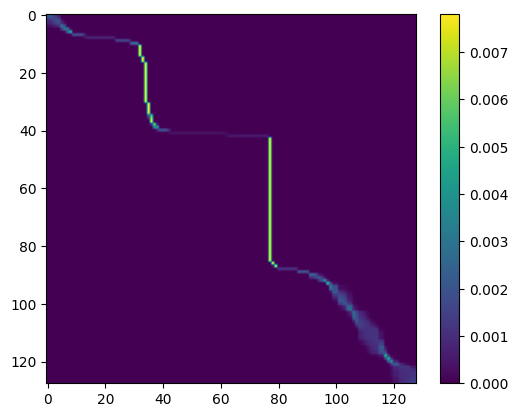

In [107]:
a,b = opw(X_train_bme[3], X_test_bme[57], type=2)
print(a)
heat_map(b)